### 导入数据

In [45]:
import skimage.io as io
import numpy as np
import math
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# 训练样本
file='./data/train/*.jpg'
coll = io.ImageCollection(file)
X_train = np.asarray(coll)                                   # 500 个训练样本，250 个猫图片，250 个非猫图片
y_train = np.hstack((np.ones(250),np.zeros(250)))            # 输出标签 
y_train = y_train.reshape((1, 500))

# 测试样本
file='./data/test/*.jpg'
coll = io.ImageCollection(file)
X_test = np.asarray(coll)                                   # 200 个训练样本，100 个猫图片，100 个非猫图片
y_test = np.hstack((np.ones(100),np.zeros(100)))            # 输出标签 
y_test = y_test.reshape((1, 200))

m_train = X_train.shape[0]
m_test = X_test.shape[0]
w, h, d = X_train.shape[1], X_train.shape[2], X_train.shape[3]

print('训练样本数量：%d' % m_train)
print('测试样本数量：%d' % m_test)
print('每张图片的维度：(%d, %d, %d)' % (w, h, d))

训练样本数量：500
测试样本数量：200
每张图片的维度：(64, 64, 3)


从训练样本中随机选择 10 张图片显示，y = 1 表示是猫类图片；y = 0 表示非猫类图片。

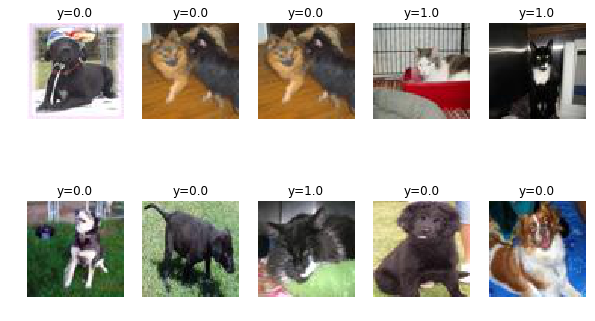

In [46]:
import matplotlib.pyplot as plt

idx = [np.random.choice(m_train) for _ in range(10)]  # 随机选择 10 张图片
label = y_train[0,idx]
for i in range(2):
    for j in range(5):
        plt.subplot(2, 5, 5*i+j+1)
        plt.imshow(X_train[idx[5*i+j]])
        plt.title("y="+str(label[5*i+j]))
        plt.axis('off')
plt.show()

### 预处理

In [47]:
# 图片矩阵转化为一维向量
X_train = X_train.reshape(m_train, -1).T
X_test = X_test.reshape(m_test, -1).T

print('训练样本维度：' + str(X_train.shape))
print('测试样本维度：' + str(X_test.shape))

训练样本维度：(12288, 500)
测试样本维度：(12288, 200)


### 网络输入标准化

In [48]:
# 首先计算均值和标准差
mean_image = np.mean(X_train, axis=1)
std_image = np.std(X_train, axis=1)
# 然后标准化
X_train = X_train.astype(float)
X_test = X_test.astype(float)
X_train -= mean_image.reshape(12288, 1)
X_train /= std_image.reshape(12288, 1)
X_test -= mean_image.reshape(12288, 1)
X_test /= std_image.reshape(12288, 1)

### 划分 Mini-Batch

In [49]:
def random_mini_batches(X, Y, mini_batch_size = 64):
    
    m = X.shape[1]                  # 训练样本数据
    mini_batches = []
        
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1,m))
    
    num_complete_minibatches = math.floor(m/mini_batch_size) # mini-batch 的个数
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # 多出的被 mini_batch_size 除不尽的一些样本再组成一个 mini-batch
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, mini_batch_size * math.floor(m/mini_batch_size) : m]
        mini_batch_Y = shuffled_Y[:, mini_batch_size * math.floor(m/mini_batch_size) : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

### 初始化 W 和 b

In [50]:
def initialize_parameters(layers_dims):
    
    parameters = {}
    L = len(layers_dims) - 1 # 网络层数
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(layers_dims[l],layers_dims[l-1]) * np.sqrt(2/layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l],1))
        
    return parameters

### 正向传播与反向传播

In [51]:
def sigmoid(x):
    
    s = 1/(1+np.exp(-x))
    return s

def relu(x):

    s = np.maximum(0,x)
    return s

def forward_propagation(X, parameters):
        
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

def backward_propagation(X, Y, cache):

    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = 1./m * (A3 - Y)
    dW3 = np.dot(dZ3, A2.T)
    db3 = np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = np.dot(dZ2, A1.T)
    db2 = np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = np.dot(dZ1, X.T)
    db1 = np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

def update_parameters_with_gd(parameters, grads, learning_rate = 0.01):

    L = len(parameters) // 2 

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * grads["db" + str(l+1)]
        
    return parameters

### 损失函数

In [52]:
def compute_cost(A3, Y):
    
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(A3),Y) + np.multiply(-np.log(1 - A3), 1 - Y)
    loss = 1./m * np.nansum(logprobs)
    
    return loss

### L2 正则化

正向传播计算 cost 过程：

In [53]:
def compute_cost_with_regularization(A3, Y, parameters, lambd):

    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    
    cross_entropy_cost = compute_cost(A3, Y) # 损失函数交叉熵
    
    L2_regularization_cost = lambd/(2*m)*(np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) # 正则化项
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

反向传播过程：

In [54]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    
    dW3 = 1./m * np.dot(dZ3, A2.T) + lambd/m*W3
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T) + lambd/m*W2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + lambd/m*W1
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

### Dropout

正向传播过程：

In [55]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.8):
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
 
    D1 = np.random.rand(A1.shape[0],A1.shape[1])      # Step 1: 初始化掩模矩阵 D1
    D1 = D1 < keep_prob                               # Step 2: D1 与阈值比较，0 or 1
    A1 = A1 * D1                                      # Step 3: 关闭一些神经元
    A1 = A1/keep_prob                                 # Step 4: scale up，保证期望值一致
    
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    
    D2 = np.random.rand(A2.shape[0],A2.shape[1])      # Step 1: 初始化掩模矩阵 D1
    D2 = D2 < keep_prob                               # Step 2: D1 与阈值比较，0 or 1
    A2 = A2 * D2                                      # Step 3: 关闭一些神经元
    A2 = A2/keep_prob                                 # Step 4: scale up，保证期望值一致

    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache

反向传播过程：

In [56]:
def backward_propagation_with_dropout(X, Y, cache, keep_prob):
    
    m = X.shape[1]
    (Z1, D1, A1, W1, b1, Z2, D2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    dA2 = np.dot(W3.T, dZ3)

    dA2 = dA2 * D2              # Step 1: 关闭一些神经元
    dA2 = dA2/keep_prob         # Step 2: scale up，保证期望值一致

    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)

    dA1 = dA1 * D1              # Step 1: 关闭一些神经元
    dA1 = dA1/keep_prob         # Step 2: scale up，保证期望值一致
    
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

### 梯度优化之 Momentum

首先对 $V_{dw}$ 和 $V_{db}$ 进行初始化：

In [57]:
def initialize_velocity(parameters):
    
    L = len(parameters) // 2     # 神经网络层数
    v = {}
    
    # 初始化 V
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters['W' + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters['b' + str(l+1)].shape)
        
    return v

Momentum 优化：

In [58]:
def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate = 0.01):

    L = len(parameters) // 2     # 神经网络层数
    
    # Momentum 更新
    for l in range(L):
        # 计算 Vdw 和 Vdb
        v["dW" + str(l+1)] = beta * v["dW" + str(l+1)] + (1 - beta) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta * v["db" + str(l+1)] + (1 - beta) * grads["db" + str(l+1)]
        # 更新参数
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v["db" + str(l+1)]
        
    return parameters, v

### 梯度优化之 Adam

首先对 $V_{dw}$、$V_{db}$、$S_{dw}$、$S_{db}$ 进行初始化：

In [59]:
def initialize_adam(parameters) :
    
    L = len(parameters) // 2     # 神经网络层数
    v = {}
    s = {}
    
    # 初始化
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
    
    return v, s

然后就是定义 Adam 梯度优化过程：

In [60]:
def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    
    L = len(parameters) // 2                 # 神经网络层数
    v_corrected = {}                         
    s_corrected = {}                         
    
    # Adam 更新
    for l in range(L):
        v["dW" + str(l+1)] = beta1 * v["dW" + str(l+1)] + (1 - beta1) * grads["dW" + str(l+1)]
        v["db" + str(l+1)] = beta1 * v["db" + str(l+1)] + (1 - beta1) * grads["db" + str(l+1)]

        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)]/(1 - np.power(beta1,t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)]/(1 - np.power(beta1,t))

        s["dW" + str(l+1)] = beta2 * s["dW" + str(l+1)] + (1-beta2) * np.power(grads["dW" + str(l+1)],2)
        s["db" + str(l+1)] = beta2 * s["db" + str(l+1)] + (1-beta2) * np.power(grads["db" + str(l+1)],2)

        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)]/(1 - np.power(beta2,t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)]/(1 - np.power(beta2,t))

        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate * v_corrected["dW" + str(l+1)]/(np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon)
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate * v_corrected["db" + str(l+1)]/(np.sqrt(s_corrected["db" + str(l+1)]) + epsilon)

    return parameters, v, s

### 构建整个模型 model

In [61]:
def model(X, Y, layers_dims, optimizer, lambd = 0, keep_prob = 1, learning_rate = 0.001, mini_batch_size = 64, 
          beta = 0.9, beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8, num_epochs = 3000, print_cost = True):

    L = len(layers_dims)             # 神经网络层数，包括输入层
    costs = []                       # 损失函数列表
    t = 0                            # Adam 算法中的迭代次数
    
    # 初始化参数
    parameters = initialize_parameters(layers_dims)

    # 初始化优化器
    if optimizer == "gd":
        pass # 没有使用梯度优化算法
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)
    
    # 迭代训练
    for i in range(num_epochs):
        
        # mini-batch
        minibatches = random_mini_batches(X, Y, mini_batch_size)

        for minibatch in minibatches:

            # 选择一组 mini-batch
            (minibatch_X, minibatch_Y) = minibatch

            # 正向传播：LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
            if keep_prob == 1:
                A3, cache = forward_propagation(minibatch_X, parameters)
            elif keep_prob < 1:
                A3, cache = forward_propagation_with_dropout(minibatch_X, parameters, keep_prob)

            # 计算 cost
            if lambd == 0:
                cost = compute_cost(A3, minibatch_Y)
            else:
                cost = compute_cost_with_regularization(A3, minibatch_Y, parameters, lambd)

            # 反向传播
            if lambd == 0 and keep_prob == 1:
                grads = backward_propagation(minibatch_X, minibatch_Y, cache)
            elif lambd != 0:
                grads = backward_propagation_with_regularization(minibatch_X, minibatch_Y, cache, lambd)
            elif keep_prob < 1:
                grads = backward_propagation_with_dropout(minibatch_X, minibatch_Y, cache, keep_prob)

            # 更新参数
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # 迭代次数 +1
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
        
        # 每隔 1000 epoch，打印 cost
        if print_cost and i % 200 == 0:
            print ("Cost after epoch %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
                
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    return parameters

### 模型预测

In [62]:
def predict(X, y, parameters):
    
    m = X.shape[1]
    p = np.zeros((1,m), dtype = np.int)
    
    # 正向传播过程
    A3, caches = forward_propagation(X, parameters)
    
    for i in range(0, A3.shape[1]):
        if A3[0,i] > 0.5:
            p[0,i] = 1
        else:
            p[0,i] = 0

    print("Accuracy: "  + str(np.mean((p[0,:] == y[0,:]))))
    
    return p

### 不使用正则化和梯度优化

Cost after epoch 0: 0.719807
Cost after epoch 200: 0.067682
Cost after epoch 400: 0.040513
Cost after epoch 600: 0.012301
Cost after epoch 800: 0.009563
Cost after epoch 1000: 0.005953
Cost after epoch 1200: 0.004771
Cost after epoch 1400: 0.004348
Cost after epoch 1600: 0.003999
Cost after epoch 1800: 0.003859
Cost after epoch 2000: 0.002428
Cost after epoch 2200: 0.001776
Cost after epoch 2400: 0.002429
Cost after epoch 2600: 0.001614
Cost after epoch 2800: 0.001663


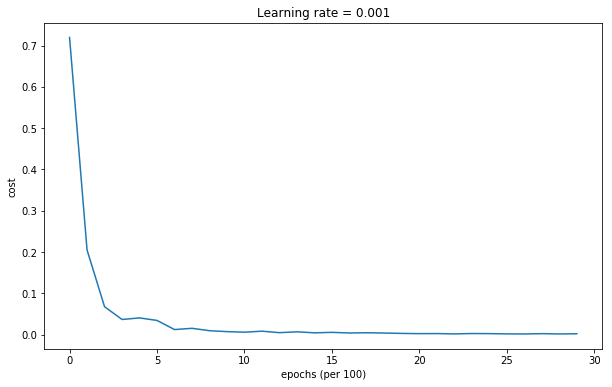

Accuracy: 1.0
Accuracy: 0.525


In [63]:
# 训练 3-layer 神经网络
layers_dims = [X_train.shape[0], 20, 10, 1]
parameters = model(X_train, y_train, layers_dims, optimizer = "gd")

# 预测训练集
predictions = predict(X_train, y_train, parameters)
# 预测测试集
predictions = predict(X_test, y_test, parameters)

In [64]:
# 预测训练集
predictions = predict(X_train, y_train, parameters)
# 预测测试集
predictions = predict(X_test, y_test, parameters)

Accuracy: 1.0
Accuracy: 0.525


### 使用 L2 正则化，Adam 优化

Cost after epoch 0: 1.097954
Cost after epoch 200: 0.024345


D:\ProgramLoc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
D:\ProgramLoc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Cost after epoch 400: 0.036834
Cost after epoch 600: 0.022035
Cost after epoch 800: 0.070609
Cost after epoch 1000: 0.022724
Cost after epoch 1200: 0.104538
Cost after epoch 1400: 0.021234
Cost after epoch 1600: 0.088165
Cost after epoch 1800: 0.021023
Cost after epoch 2000: 0.026286
Cost after epoch 2200: 0.015563
Cost after epoch 2400: 0.025537
Cost after epoch 2600: 0.050002
Cost after epoch 2800: 0.047617


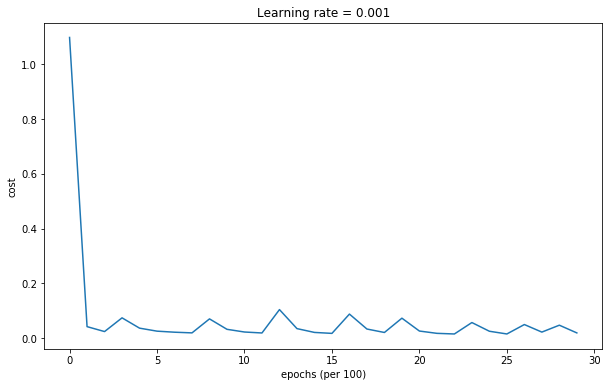

Accuracy: 1.0
Accuracy: 0.545


In [65]:
# 训练 3-layer 神经网络
layers_dims = [X_train.shape[0], 20, 10, 1]
parameters = model(X_train, y_train, layers_dims, lambd = 0.1, optimizer = "adam")

# 预测训练集
predictions = predict(X_train, y_train, parameters)
# 预测测试集
predictions = predict(X_test, y_test, parameters)

### 使用 Dropout，Adam 优化

Cost after epoch 0: 3.390538


D:\ProgramLoc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.
D:\ProgramLoc\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in multiply
  after removing the cwd from sys.path.


Cost after epoch 200: 0.070044
Cost after epoch 400: 0.086490
Cost after epoch 600: 0.093776
Cost after epoch 800: 0.048461
Cost after epoch 1000: 0.006210
Cost after epoch 1200: 0.002600
Cost after epoch 1400: 0.001356
Cost after epoch 1600: 0.010101
Cost after epoch 1800: 0.069984
Cost after epoch 2000: 0.002017
Cost after epoch 2200: 0.000373
Cost after epoch 2400: 0.000551
Cost after epoch 2600: 0.000583
Cost after epoch 2800: 0.000180


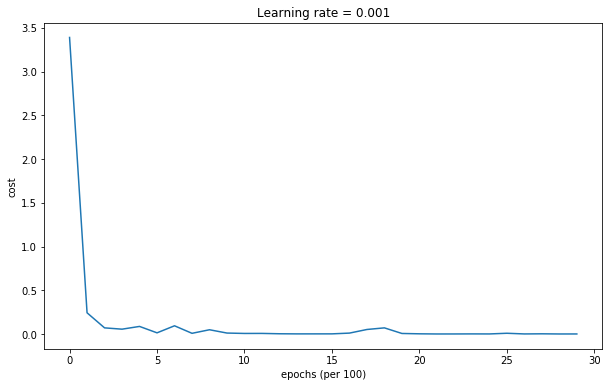

Accuracy: 1.0
Accuracy: 0.585


In [66]:
# 训练 3-layer 神经网络
layers_dims = [X_train.shape[0], 20, 10, 1]
parameters = model(X_train, y_train, layers_dims, keep_prob = 0.8, optimizer = "adam")

# 预测训练集
predictions = predict(X_train, y_train, parameters)
# 预测测试集
predictions = predict(X_test, y_test, parameters)